In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import open3d as o3d
from datetime import datetime
from shutil import copyfile

from utils import *
from bpy_utils import ManusData, get_fbx_creation_time

import sys
manopth_dir = 'C:/Users/lucas/Desktop/UPC/MIT/manopth/'
sys.path.insert(1, manopth_dir)

from manus.utils import Pressure
from manus.sensors import SensorsLocation

In [3]:
recording = "round_2_fixed_wooden_cube/"
recording = "round_3_fixed_bottle_pose_1/"

data_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/real_data/data"
recording = "20210727_woIMU/r4/"
recording_dir = os.path.join(data_dir, recording)

for name in os.listdir(recording_dir):
    name_pth = os.path.join(recording_dir, name)
    
    if os.path.isdir(name_pth):
        print("cameras_dir:", name)
        cameras_dir = name_pth
        
    elif ".hdf5" in name:
        print("pressure_file:", name)
        perssure_pth = name_pth
        
    elif ".fbx" in name:
        print("manus_file:", name)
        manus_pth = name_pth
        
#cameras_dir = os.path.join(recording_dir, "20210722_152500")
#perssure_pth = os.path.join(recording_dir, ".hdf5")
#manus_pth = os.path.join(recording_dir, ".fbx")

pressure_file: 07272021_4.hdf5
cameras_dir: 20210727_173520
manus_file: recording_2021-07-27_16-36-27.fbx


# Load data

In [4]:
%%capture

cameras = ["020122061233", "821312060044", "020122061651", "821312062243"]

intrinsics = Intrinsics(cameras_dir, use_txt=False)
extrinsics = Extrinsics(cameras_dir)
rgbds = RGBD(cameras_dir)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)
apriltags = AprilTags(cameras_dir, intrinsics, extrinsics, cameras=cameras)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)

pressure = Pressure(perssure_pth, lim_low=3, lim_high=50)

manus = ManusData(manus_pth, manopth_dir)

glove_sensor_path = os.path.join(manopth_dir, 'data/glove_vis_sensor_new.csv')
sensors_location = SensorsLocation(glove_sensor_path)

# Synchronize

#### Get timestamps

In [5]:
# Camera timestamps
ts_camera = get_camera_timestamps(cameras_dir)

# Pressure timestamps
ts_pressure = pressure.ts_touch

# MANUS timestamp
#pyfbx_i42_pth = "C:/Users/lucas/Desktop/UPC/MIT/pyfbx_i42-master/"
#ts_end = get_fbx_creation_time(manus_pth, pyfbx_i42_pth)
#ts_start = ts_end - len(manus) / 24
ts_manus = manus.get_ts(fps=19.67)

#### Find pressure camera offset


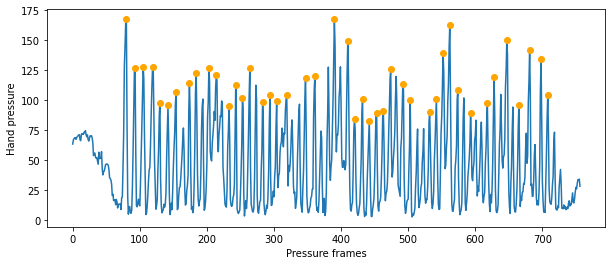

In [6]:
pressure.plot_peaks(height=80)

In [7]:
# Index of first pressure peak 
idx_first_p = pressure.get_peaks(height=80)[0]
# Timestamp of first pressure peak
ts_first_p = pressure.ts_touch[idx_first_p]

# Frame of first pressure in camera
frame_first_c = 113
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
pc_offset = ts_first_p - ts_first_c

#### Find manus camera offset


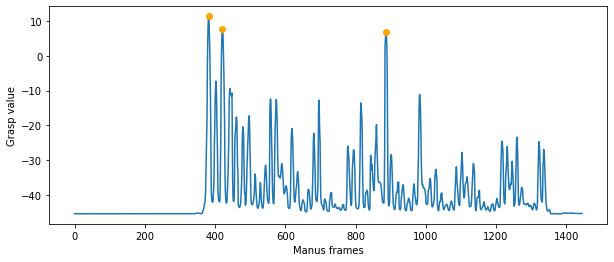

In [8]:
manus.plot_grasps(height=5)

In [9]:
# Index of first manus grasp peak 
idx_first_m = manus.get_grasps(height=5)[0]
# Timestamp of first manus grasp peak
ts_first_m = ts_manus[idx_first_m]

# Frame of first grasp in camera
frame_first_c = 113
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
mc_offset = ts_first_m - ts_first_c

#### Synchronize pressure + camera + manus

In [10]:
synchronize = Synchronizer(ts_p=ts_pressure, ts_c=ts_camera, ts_m=ts_manus, pc_offset=pc_offset, mc_offset=mc_offset)

# Extract point clouds

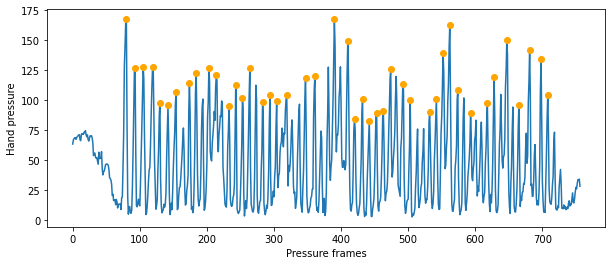

In [11]:
pressure.plot_peaks(height=80)

In [12]:
# Pressure frames where there are grasps
grasp_p_frames = pressure.get_peaks(height=80)
# Manus frames where there are grasps
grasp_m_frames = synchronize.pressure_to_manus(grasp_p_frames)

In [13]:
pointclouds = []
pointcloud_sensors = []

for grasp_p_frame in zip(grasp_p_frames):
    grasp_m_frame = synchronize.pressure_to_manus(grasp_p_frame)
    grasp_c_frame = synchronize.pressure_to_camera(grasp_p_frame)
    
    # Corner location of the AprilTag in world coordinates
    corners_w = apriltags.corners_w(idx=grasp_c_frame)
    
    if corners_w is not None:
        # Get manus verts at that frame
        hand_verts = manus.hand_verts_from_corners(grasp_m_frame, corners_w)
    
        # Get sensor location for that particular hand position
        sensors_xyz = sensors_location.from_hand_verts(hand_verts)

        # Get pressure at that particular frame
        response = pressure[grasp_p_frame]
        # Get pressure for each sensor index
        response = response.reshape(-1)[sensors_location.sensor_idx]
    
    
        idx_on = (response > 0.8).nonzero()
        pointclouds.append(sensors_xyz[idx_on,:][0])

        
all_pointclouds = np.concatenate( pointclouds, axis=0 )

In [14]:
all_pcd = o3d.geometry.PointCloud()
all_pcd.points = o3d.utility.Vector3dVector(all_pointclouds)
all_pcd.paint_uniform_color([0, 0, 0])
o3d.visualization.draw_geometries([all_pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


# Estimate object location

In [15]:
%%capture

pcd = stitched_pcd["000000"]

obj_name = "005_tomato_soup_can"
obj_name = "003_cracker_box"
obj_name = "036_wood_block"
obj_name = "006_mustard_bottle"

obj_pth = f"C:/Users/lucas/Desktop/UPC/MIT/tactile2object/estimate_object_pose/ycb_converted/{obj_name}.ply"

# Useful when running the cell multiple times
try:
    obj_mesh_t # obj_mesh_t exist in the current namespace
except NameError:
    transformation, obj_mesh_t = find_object_transformation(pcd, obj_pth)

In [17]:
o3d.visualization.draw_geometries([all_pcd, obj_mesh_t])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


We move the pressure points to the object location

In [18]:
pcd_pressure = copy.deepcopy(all_pcd)
pcd_pressure.transform(np.linalg.inv(transformation))
pcd_pressure.estimate_normals()
pcd_pressure.orient_normals_consistent_tangent_plane(50)

# Save to CON
TODO: There is a scale problem

In [19]:
# For supervision. We will get the scale and rotation from here
points_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/ycb/4_points"

dataset_dir = os.path.join(data_dir, "real_dataset")
out_dir = os.path.join(dataset_dir, recording.split("/")[0], obj_name)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)    

##### Create files

In [20]:
pc_pth = os.path.join(points_dir, f"{obj_name}.npz")
pc_npz = np.load(pc_pth)
translation = pc_npz['loc'].tolist()
scale = pc_npz['scale'].item()

points = (np.asarray(pcd_pressure.points) - translation) / scale
normals = np.asarray(pcd_pressure.normals)

npz_pth = os.path.join(out_dir, "pointcloud.npz")
np.savez(npz_pth, 
         points=points, 
         normals=normals,
         loc=pc_npz['loc'],
         scale=pc_npz['scale']
         )

dst_pth_ps = os.path.join(out_dir, "points.npz")
copyfile(pc_pth, dst_pth_ps)

# Save point cloud
pcd_out_pth = os.path.join(out_dir, "pcd.ply")
pcd_out = o3d.geometry.PointCloud()
pcd_out.points = o3d.utility.Vector3dVector(points)
pcd_out.normals = o3d.utility.Vector3dVector(normals)
o3d.io.write_point_cloud(pcd_out_pth, pcd_out) 

True

##### Create test.lst file

In [21]:
for recording_name in os.listdir(dataset_dir):
    file_dir = os.path.join(dataset_dir, recording_name)
    test_pth = os.path.join(file_dir, 'test.lst')

    with open(test_pth, 'w') as filehandle:
        for object_name in os.listdir(file_dir):
            if os.path.isdir(os.path.join(file_dir, object_name)):
                filehandle.write('%s\n' % object_name)